In [87]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

In [88]:
import pandas as pd
import wandb
import numpy as np

api = wandb.Api()

entity = "tunnels-ssl"
project = "01.25"
# Get all runs for the specified project
runs = api.runs(f"{entity}/{project}")


summary_list, config_list, name_list = [], [], []
for run in runs:
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files
    summary_list.append(run.summary._json_dict["test/avg_acc_tag"])

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append({k: v for k, v in run.config.items() if not k.startswith("_")})

    # .name is the human-readable name of the run.
    name_list.append(run.name)

runs_df = pd.DataFrame(
    {"avg_acc_tag": summary_list, "config": config_list, "name": name_list}
)
config_df = pd.json_normalize(runs_df["config"])
df = pd.concat([runs_df.drop(columns=["config"]), config_df], axis=1)
df["data.dataset"] = df["data.datasets"].apply(lambda x: x[0])


def get_real_name(row):
    if row["data.exemplars.num_exemplars"] > 0:
        return "replay"
    return row["training.approach.name"]


def is_regularized(row):
    if row["training.vcreg.var_weight"] == 0 and row["training.vcreg.cov_weight"] == 0:
        return False
    return True


df["approach"] = df.apply(get_real_name, axis=1)
df["is_regularized"] = df.apply(is_regularized, axis=1)

In [92]:
# dataset = "imagenet"
# network = "resnet34_skips"
network = "convnext_tiny"
approach = "lwf"

df_a = df[
    (df["approach"].str.contains(approach))
    # & (df["data.datasets"].str.contains(dataset))
    & (df["model.network"].str.contains(network))
]

all_df = pd.read_csv("all.csv")
noreg = all_df[all_df["is_regularized"] == False]
# all_df.query(
#     "num_tasks == 10 and approach == 'replay' and dataset=='cifar100_fixed' and network=='resnet34_skips'"
# )

<Axes: xlabel='training.vcreg.cov_weight', ylabel='training.vcreg.var_weight'>

Text(0.5, 1.0, "network='convnext_tiny', data='imagenet_subset_kaggle' approach='lwf'")

Text(0.5, 25.722222222222214, 'Cov Weight')

Text(158.22222222222223, 0.5, 'Var Weight')

<Axes: xlabel='training.vcreg.cov_weight', ylabel='training.vcreg.var_weight'>

Text(0.5, 1.0, "network='convnext_tiny', data='cifar100_fixed' approach='lwf'")

Text(0.5, 25.722222222222214, 'Cov Weight')

Text(792.3131313131312, 0.5, 'Var Weight')

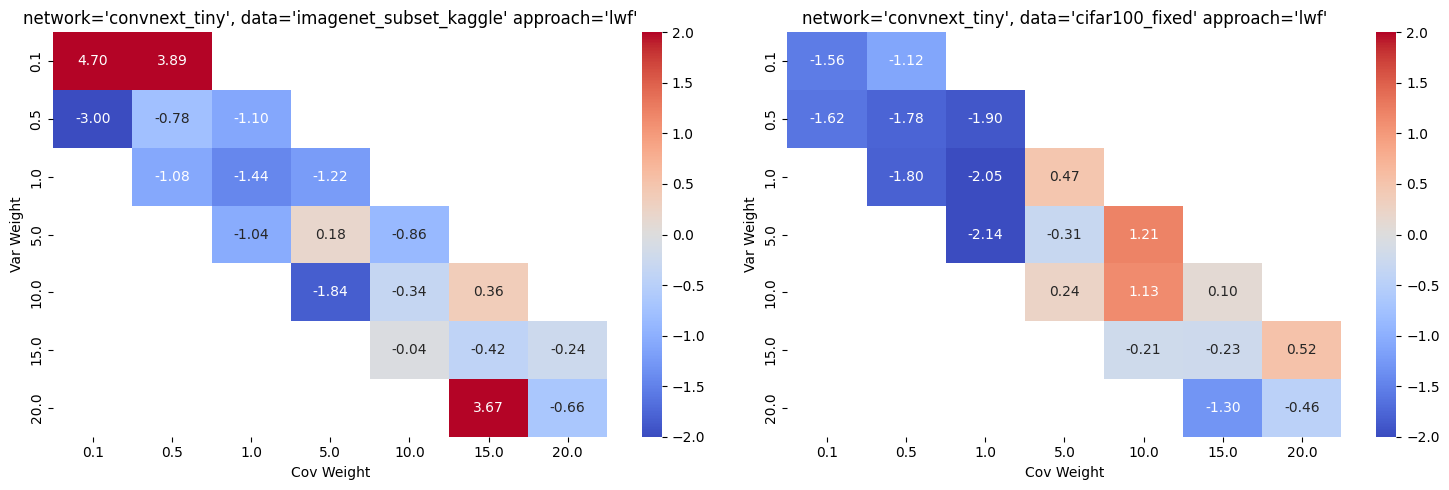

In [93]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

results = []
# Sample DataFrame creation (for demonstration purposes)
# Get unique values of reg_layers
# unique_reg_layers = df_a["training.vcreg.reg_layers"].unique()
unique_reg_layers = df_a["data.dataset"].unique()

# Create a figure for the heatmaps
fig, axes = plt.subplots(1, len(unique_reg_layers), figsize=(15, 5))

if len(unique_reg_layers) == 1:
    axes = [axes]
# Loop through each unique reg_layer to create a heatmap
for i, data in enumerate(unique_reg_layers):
    # Filter data for the current reg_layer
    filtered_df = df_a[df_a["data.dataset"] == data]
    # __import__("pdb").set_trace()
    # Create a pivot table for the heatmap
    vals = noreg.query(
        f"num_tasks == 10 and approach == '{approach}' and dataset == '{data}' and seed== 0 and network == '{network}'"
    )["avg_acc_tag"]
    assert len(vals) == 1
    pivot_table = filtered_df.pivot_table(
        index="training.vcreg.var_weight",
        columns="training.vcreg.cov_weight",
        values="avg_acc_tag",
        # fill_value=-1,
        aggfunc=lambda x: x - vals.iloc[0],
        # aggfunc=lambda x: x - noreg_data[f"{dataset}_{network}"],
    )
    results.append(pivot_table)
    # Draw the heatmap
    sns.heatmap(
        pivot_table,
        annot=True,
        cmap="coolwarm",
        vmin=-2,
        vmax=2,
        center=0,
        ax=axes[i],
        cbar=True,
        fmt=".2f",
    )

    # Set title for each subplot
    axes[i].set_title(f"{network=}, {data=} {approach=}")
    axes[i].set_xlabel("Cov Weight")
    axes[i].set_ylabel("Var Weight")

# Adjust layout
plt.tight_layout()
plt.show()

In [94]:
xx = sum(results).reset_index()
melted_table = pd.melt(
    xx,
    id_vars=["training.vcreg.var_weight"],  # Variables to keep fixed
    var_name="training.vcreg.cov_weight",  # Name for the column created from columns
    value_name="test_acc",  # Name for the values column
)

training.vcreg.cov_weight,0.1,0.5,1.0,5.0,10.0,15.0,20.0
training.vcreg.var_weight,,,,,,,
0.1,3.14±0.00,2.77±0.00,nan±nan,nan±nan,nan±nan,nan±nan,nan±nan
0.5,-4.62±0.00,-2.56±0.00,-3.00±0.00,nan±nan,nan±nan,nan±nan,nan±nan
1.0,nan±nan,-2.88±0.00,-3.49±0.00,-0.75±0.00,nan±nan,nan±nan,nan±nan
5.0,nan±nan,nan±nan,-3.18±0.00,-0.13±0.00,0.35±0.00,nan±nan,nan±nan
10.0,nan±nan,nan±nan,nan±nan,-1.60±0.00,0.79±0.00,0.46±0.00,nan±nan
15.0,nan±nan,nan±nan,nan±nan,nan±nan,-0.25±0.00,-0.65±0.00,0.28±0.00
20.0,nan±nan,nan±nan,nan±nan,nan±nan,nan±nan,2.37±0.00,-1.12±0.00


<Axes: xlabel='training.vcreg.cov_weight', ylabel='training.vcreg.var_weight'>

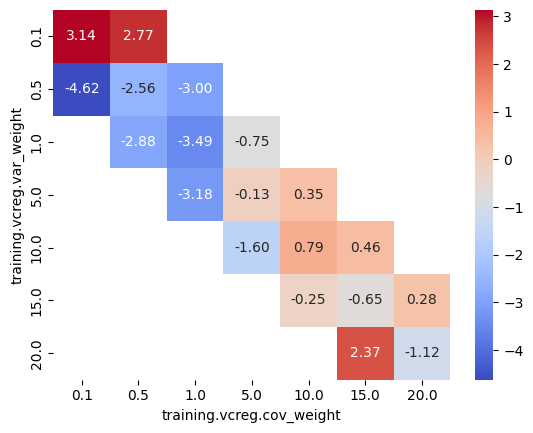

In [95]:
melted = melted_table.pivot_table(
    index="training.vcreg.var_weight",
    columns="training.vcreg.cov_weight",
    values="test_acc",
    # aggfunc=lambda x: f"{np.mean(x):.2f}±{np.var(x):.2f}",
    aggfunc=lambda x: np.mean(x),
)
melted_table.pivot_table(
    index="training.vcreg.var_weight",
    columns="training.vcreg.cov_weight",
    values="test_acc",
    aggfunc=lambda x: f"{np.mean(x):.2f}±{np.var(x):.2f}",
)
sns.heatmap(
    melted,
    cbar=True,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
)

In [100]:
df_a["training.vcreg.var_weight"].unique()

array([ 0.1,  0.5,  1. ,  5. , 15. , 10. , 20. ])

In [103]:
[0.1, 0.5, 1.0, 5.0, 15.0, 10.0, 20.0]

[0.1, 0.5, 1.0, 5.0, 15.0, 10.0, 20.0]

In [104]:
import numpy as np
import itertools

# Define the set of values
values = [0.1, 0.5, 1.0, 5.0, 15.0, 10.0, 20.0]

# Create the Cartesian product of values (all possible pairs)
cartesian_product = np.array(list(itertools.product(values, repeat=2)))

In [239]:
# Function to uniformly draw a pair (x, y) from the Cartesian product
def sample_pairs(cartesian_product, n_samples=1):
    """
    Uniformly sample pairs from the Cartesian product.

    Args:
        cartesian_product (numpy.ndarray): Array of shape (k, 2) containing the pairs.
        n_samples (int): Number of pairs to sample.

    Returns:
        numpy.ndarray: Array of sampled pairs.
    """
    indices = np.random.choice(cartesian_product, size=n_samples, replace=False)
    indices = np.random.randint(cartesian_product.shape[0])
    return cartesian_product[indices]

In [241]:
n_samples = 15
sampled_pairs = sample_pairs(cartesian_product, n_samples)
print("Sampled Pairs:")
print(sampled_pairs)
x = sampled_pairs[:, 0]
y = sampled_pairs[:, 1]
sns.scatterplot(x=x, y=y, marker="o", color="blue", s=100, edgecolor="black")

# Add labels and title
plt.title("Uniformly Sampled Pairs from Cartesian Product", fontsize=14)
plt.xlabel("x", fontsize=12)
plt.ylabel("y", fontsize=12)

# Show the plot
plt.show()

ValueError: a must be 1-dimensional

<Figure size 800x600 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Uniformly Sampled Pairs from Cartesian Product')

Text(0.5, 0, 'x')

Text(0, 0.5, 'y')

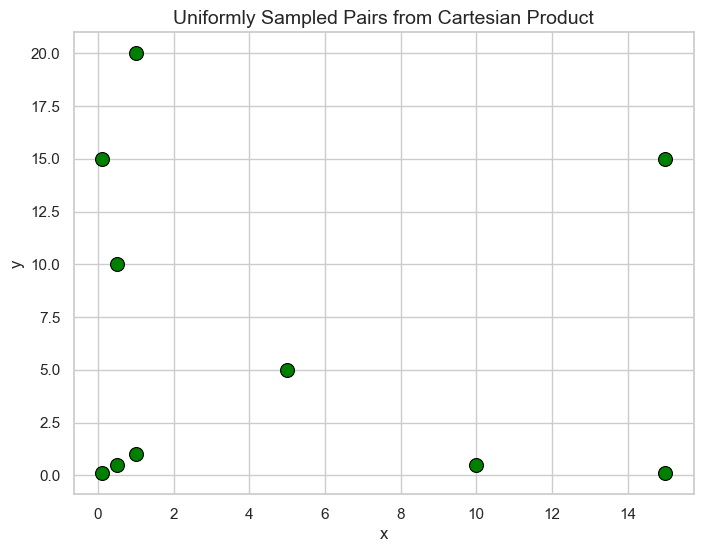

In [144]:
def uniform_sampling(cartesian_product, n_points):
    """
    Uniformly sample pairs from the Cartesian product.

    Args:
        cartesian_product (numpy.ndarray): Array of shape (k, 2) containing the pairs.
        n_points (int): Total number of points to sample evenly.

    Returns:
        numpy.ndarray: Array of sampled pairs.
    """
    # Select uniform indices across the grid
    step = len(cartesian_product) // n_points
    indices = np.arange(0, len(cartesian_product), step)
    return cartesian_product[indices[:n_points]]
    n_points = 10
    sampled_pairs = uniform_sampling(cartesian_product, n_points)


# Convert sampled pairs into x and y arrays
x = sampled_pairs[:, 0]
y = sampled_pairs[:, 1]

# Plot the uniformly spaced pairs using Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

# Scatter plot
sns.scatterplot(x=x, y=y, marker="o", color="green", s=100, edgecolor="black")

# Add labels and title
plt.title("Uniformly Sampled Pairs from Cartesian Product", fontsize=14)
plt.xlabel("x", fontsize=12)
plt.ylabel("y", fontsize=12)

# Show the plot
plt.show()

<Figure size 800x600 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Uniformly Sampled Pairs from Cartesian Product')

Text(0.5, 0, 'x')

Text(0, 0.5, 'y')

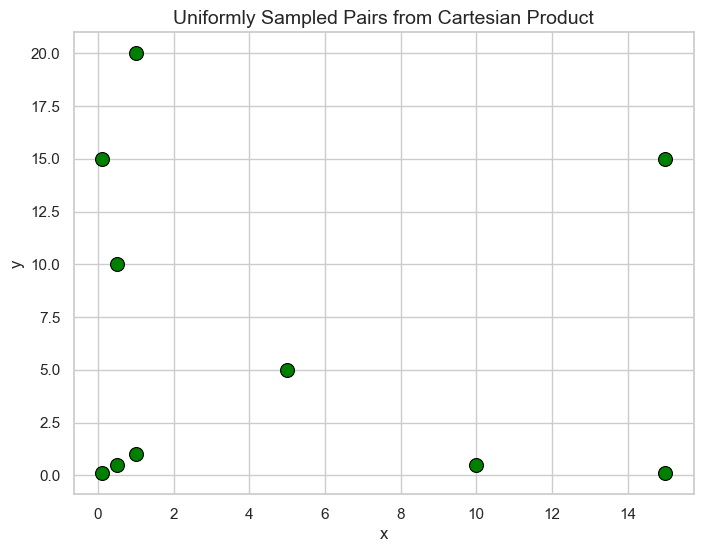

In [242]:
cartesian_product

array([[ 0.1,  0.1],
       [ 0.1,  0.5],
       [ 0.1,  1. ],
       [ 0.1,  5. ],
       [ 0.1, 15. ],
       [ 0.1, 10. ],
       [ 0.1, 20. ],
       [ 0.5,  0.1],
       [ 0.5,  0.5],
       [ 0.5,  1. ],
       [ 0.5,  5. ],
       [ 0.5, 15. ],
       [ 0.5, 10. ],
       [ 0.5, 20. ],
       [ 1. ,  0.1],
       [ 1. ,  0.5],
       [ 1. ,  1. ],
       [ 1. ,  5. ],
       [ 1. , 15. ],
       [ 1. , 10. ],
       [ 1. , 20. ],
       [ 5. ,  0.1],
       [ 5. ,  0.5],
       [ 5. ,  1. ],
       [ 5. ,  5. ],
       [ 5. , 15. ],
       [ 5. , 10. ],
       [ 5. , 20. ],
       [15. ,  0.1],
       [15. ,  0.5],
       [15. ,  1. ],
       [15. ,  5. ],
       [15. , 15. ],
       [15. , 10. ],
       [15. , 20. ],
       [10. ,  0.1],
       [10. ,  0.5],
       [10. ,  1. ],
       [10. ,  5. ],
       [10. , 15. ],
       [10. , 10. ],
       [10. , 20. ],
       [20. ,  0.1],
       [20. ,  0.5],
       [20. ,  1. ],
       [20. ,  5. ],
       [20. , 15. ],
       [20. ,

/var/folders/7p/77w4_2b565n0b8phw5c6dvtm0000gp/T/ipykernel_14751/2977515800.py:1: DeprecationWarning: This function is deprecated. Please call randint(0, 48 + 1) instead
  indices  = np.random.random_integers(0, cartesian_product.shape[0]-1, 10)


array([[ 5. , 10. ],
       [10. ,  5. ],
       [20. , 10. ],
       [15. ,  0.5],
       [ 1. ,  0.1],
       [ 5. , 15. ],
       [ 1. ,  0.1],
       [15. ,  0.5],
       [20. , 20. ],
       [15. , 10. ]])

<Axes: >

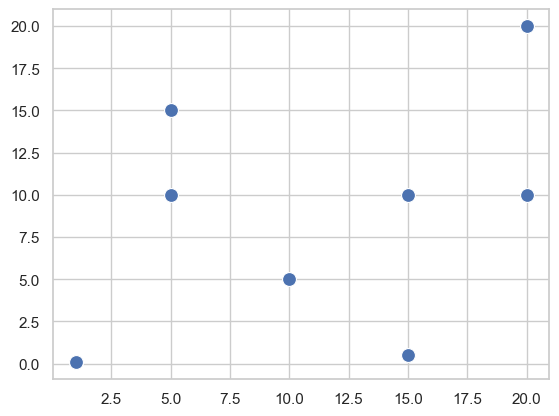

In [354]:
indices = np.random.random_integers(0, cartesian_product.shape[0] - 1, 10)
sample_pairs = cartesian_product[indices]
x = sample_pairs[:, 0]
y = sample_pairs[:, 1]
sample_pairs
# Plot the uniformly spaced pairs using Seaborn
# Scatter plot
sns.scatterplot(x=x, y=y, marker="o", s=100)

In [ ]:
sample_pairs.tolist().extend([0, 0])

In [4]:
sample_pairs = [
    [0.0, 0.0],
    [5.0, 10.0],
    [10.0, 5.0],
    [20.0, 10.0],
    [15.0, 0.5],
    [1.0, 0.1],
    [5.0, 15.0],
    [1.0, 0.1],
    [15.0, 0.5],
    [20.0, 20.0],
    [15.0, 10.0]
]

In [5]:
res = []
layers = [".*classifier", ".*after_skipping"]
for var, cov in sample_pairs:
    for layer in layers:
        res.append({"reg_layers": layer, "var_weight": var, "cov_weight": cov})
res[1:]

[{'reg_layers': '.*after_skipping', 'var_weight': 0.0, 'cov_weight': 0.0},
 {'reg_layers': '.*classifier', 'var_weight': 5.0, 'cov_weight': 10.0},
 {'reg_layers': '.*after_skipping', 'var_weight': 5.0, 'cov_weight': 10.0},
 {'reg_layers': '.*classifier', 'var_weight': 10.0, 'cov_weight': 5.0},
 {'reg_layers': '.*after_skipping', 'var_weight': 10.0, 'cov_weight': 5.0},
 {'reg_layers': '.*classifier', 'var_weight': 20.0, 'cov_weight': 10.0},
 {'reg_layers': '.*after_skipping', 'var_weight': 20.0, 'cov_weight': 10.0},
 {'reg_layers': '.*classifier', 'var_weight': 15.0, 'cov_weight': 0.5},
 {'reg_layers': '.*after_skipping', 'var_weight': 15.0, 'cov_weight': 0.5},
 {'reg_layers': '.*classifier', 'var_weight': 1.0, 'cov_weight': 0.1},
 {'reg_layers': '.*after_skipping', 'var_weight': 1.0, 'cov_weight': 0.1},
 {'reg_layers': '.*classifier', 'var_weight': 5.0, 'cov_weight': 15.0},
 {'reg_layers': '.*after_skipping', 'var_weight': 5.0, 'cov_weight': 15.0},
 {'reg_layers': '.*classifier', 'var_

In [6]:
res = []
layers = [".*fc", ".*after_relu"]
for var, cov in sample_pairs:
    for layer in layers:
        res.append({"reg_layers": layer, "var_weight": var, "cov_weight": cov})
res[1:]

[{'reg_layers': '.*after_relu', 'var_weight': 0.0, 'cov_weight': 0.0},
 {'reg_layers': '.*fc', 'var_weight': 5.0, 'cov_weight': 10.0},
 {'reg_layers': '.*after_relu', 'var_weight': 5.0, 'cov_weight': 10.0},
 {'reg_layers': '.*fc', 'var_weight': 10.0, 'cov_weight': 5.0},
 {'reg_layers': '.*after_relu', 'var_weight': 10.0, 'cov_weight': 5.0},
 {'reg_layers': '.*fc', 'var_weight': 20.0, 'cov_weight': 10.0},
 {'reg_layers': '.*after_relu', 'var_weight': 20.0, 'cov_weight': 10.0},
 {'reg_layers': '.*fc', 'var_weight': 15.0, 'cov_weight': 0.5},
 {'reg_layers': '.*after_relu', 'var_weight': 15.0, 'cov_weight': 0.5},
 {'reg_layers': '.*fc', 'var_weight': 1.0, 'cov_weight': 0.1},
 {'reg_layers': '.*after_relu', 'var_weight': 1.0, 'cov_weight': 0.1},
 {'reg_layers': '.*fc', 'var_weight': 5.0, 'cov_weight': 15.0},
 {'reg_layers': '.*after_relu', 'var_weight': 5.0, 'cov_weight': 15.0},
 {'reg_layers': '.*fc', 'var_weight': 1.0, 'cov_weight': 0.1},
 {'reg_layers': '.*after_relu', 'var_weight': 1.0,